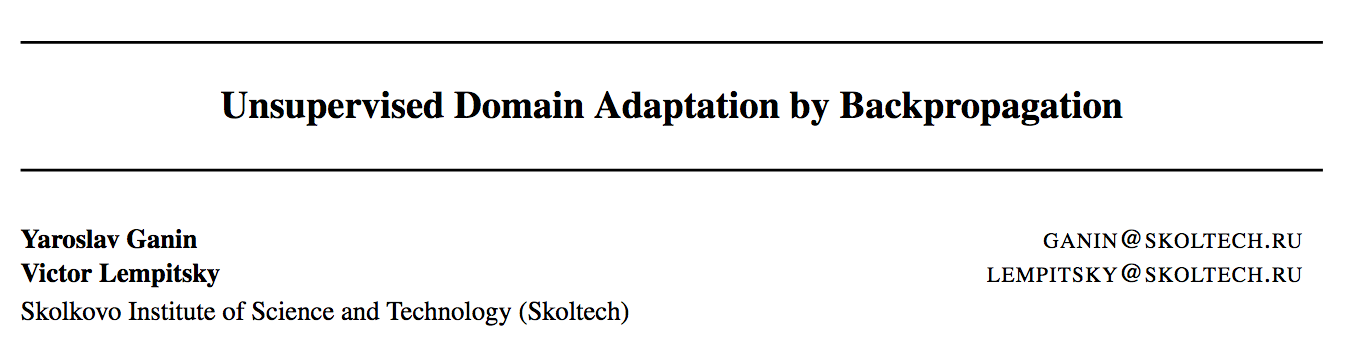

<center>Team 37-UNO<br></center>
Krati agrawal - 2022201063<br>
Anuja gulhane - 2022201070<br>
Hrishikesh Deshpande -2022201065


Implementation of the paper **Unsupervised Domain Adaptation by Backpropagation** 
https://arxiv.org/abs/1409.7495

In [2]:
%matplotlib inline

<h1>Importing Libraries</h1>

In [4]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

We are going to do a **domain adaptation** from a source dataset (SVHN) towards a target dataset (MNIST).

First, we need to create the target dataset.

Then, let's load the MNIST and SVHM datasets and compute their (train!) mean and standard deviation.

We will use those values to **standardize** both the datasets.

In [ ]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

100%|██████████| 9912422/9912422 [00:00<00:00, 294116436.60it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 55439676.81it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 160134560.45it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21453298.16it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
# mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

target_train_loader = DataLoader(mnist_train, batch_size=128)
target_test_loader = DataLoader(mnist_test, batch_size=128)

In [ ]:
len(mnist_train)
len(mnist_test)

10000

In [ ]:
dataiter = iter(target_train_loader)
images, labels = next(dataiter)
print(images.shape)

torch.Size([128, 3, 28, 28])


... and visualize!

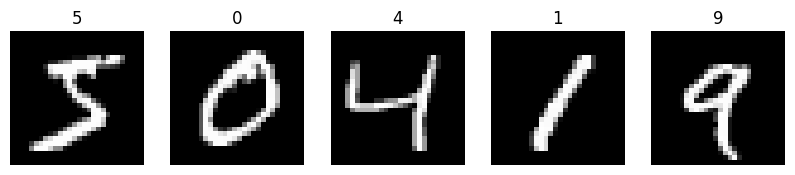

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

In [ ]:
svhn_pixels = torchvision.datasets.SVHN(root='./data', split='train', transform=transform, download=True).data/255
mean2 = svhn_pixels.mean().item()
std2 = svhn_pixels.std().item()
print(f"Mean {mean2} and Std {std2}")
mean2 = torch.tensor([mean2, mean2, mean2])
std2 = torch.tensor([std2, std2, std2])

100%|██████████| 182040794/182040794 [00:05<00:00, 31156660.19it/s]


Mean 0.4514187438009213 and Std 0.19929124669110956


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean2, std=std2)
])

# Load the training set
svhn_train = torchvision.datasets.SVHN(root='./data', split='train', transform=transform, download=True)

# Load the test set
svhn_test = torchvision.datasets.SVHN(root='./data', split='test', transform=transform, download=True)

# Create data loaders for the training and test sets
source_train_loader = torch.utils.data.DataLoader(svhn_train, batch_size=128, shuffle=True)
source_test_loader = torch.utils.data.DataLoader(svhn_test, batch_size=128, shuffle=False)


Using downloaded and verified file: ./data/train_32x32.mat


100%|██████████| 64275384/64275384 [00:02<00:00, 22508633.92it/s]


In [ ]:
len(svhn_train)
len(svhn_test)

26032

In [ ]:
dataiter2 = iter(source_train_loader)
images, labels = next(dataiter2)
print(images.shape)

torch.Size([128, 3, 28, 28])


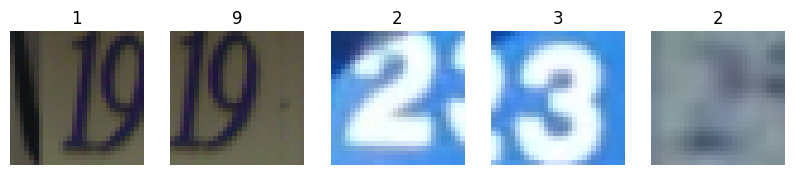

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = svhn_train[i]
  img = ((x * std2[:, None, None] + mean2[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

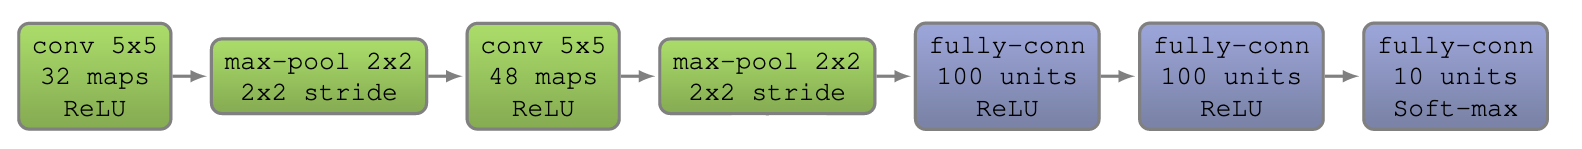

In [ ]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        #28*28*3
        nn.Conv2d(3, 64, kernel_size=5,padding=3),  # 64x30x30
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),  # 64x14x14
        nn.Conv2d(64, 64, kernel_size=5,padding=2),  # 64x14x14
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),  # 64x6x6

        nn.Conv2d(64, 128, kernel_size=5),  # 128x2x2
        nn.ReLU(inplace=True),
    )
    # size= 32*32*3
    # self.cnn = nn.Sequential(
    #     nn.Conv2d(3, 64, kernel_size=5,padding=2),  # 64x28x28
    #     nn.ReLU(inplace=True),
    #     nn.MaxPool2d(kernel_size=3, stride=2),  # 64x13x13
    #     nn.Conv2d(64, 64, kernel_size=5),  # 64x9x9
    #     nn.ReLU(inplace=True),
    #     nn.MaxPool2d(kernel_size=3, stride=2),  # 64x4x4

    #     nn.Conv2d(64, 128, kernel_size=5),  # 128x7x7
    #     nn.ReLU(inplace=True),
    # )

    self.classif = nn.Sequential(
        nn.Linear(512, 3072),
        nn.ReLU(inplace=True),
        nn.Linear(3072, 2048),
        nn.ReLU(inplace=True),
        nn.Linear(2048, 10)
    )

  def forward(self, x):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)
    return self.classif(x)


# NaiveNet()(torch.randn(64, 3, 28, 28)).shape

In [ ]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (SVHN) dataset. We will evaluate its performance on the target (MNIST) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification. 

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [ ]:
epochs = 70

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=0.01, momentum=0.9)

# mu0, alpha, beta = 0.01, 10, 0.75
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lambda e: mu0 / (1 + alpha * e / epochs) ** beta
# )

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  # scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 1.34346
	Learning rate = 0.01
Epoch 1, train loss: 0.41782
	Learning rate = 0.01
Epoch 2, train loss: 0.32181
	Learning rate = 0.01
Epoch 3, train loss: 0.26769
	Learning rate = 0.01
Epoch 4, train loss: 0.23122
	Learning rate = 0.01
Epoch 5, train loss: 0.20045
	Learning rate = 0.01
Epoch 6, train loss: 0.17407
	Learning rate = 0.01
Epoch 7, train loss: 0.14963
	Learning rate = 0.01
Epoch 8, train loss: 0.1281
	Learning rate = 0.01
Epoch 9, train loss: 0.10671
	Learning rate = 0.01
Epoch 10, train loss: 0.089
	Learning rate = 0.01
Epoch 11, train loss: 0.08106
	Learning rate = 0.01
Epoch 12, train loss: 0.05958
	Learning rate = 0.01
Epoch 13, train loss: 0.05635
	Learning rate = 0.01
Epoch 14, train loss: 0.04923
	Learning rate = 0.01
Epoch 15, train loss: 0.04395
	Learning rate = 0.01
Epoch 16, train loss: 0.04156
	Learning rate = 0.01
Epoch 17, train loss: 0.04108
	Learning rate = 0.01
Epoch 18, train loss: 0.03334
	Learning rate = 0.01
Epoch 19, train loss: 0.0

In [ ]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 9.67681, test acc: 67.01


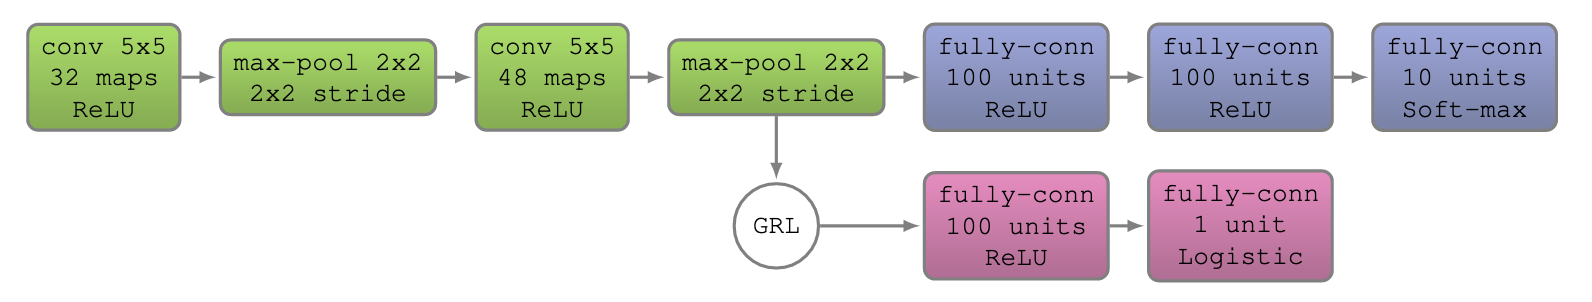

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [ ]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    return factor * grad, None


In [ ]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply 

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

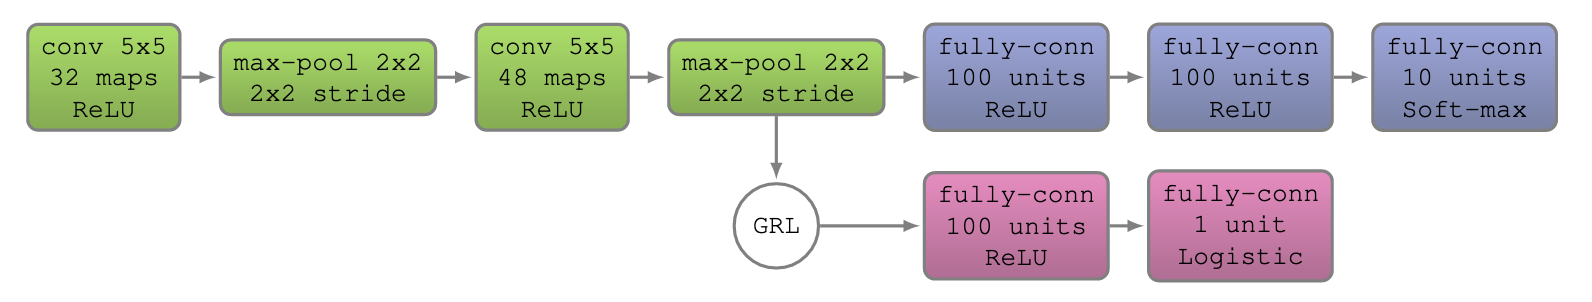

In [ ]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__() 
    self.cnn = nn.Sequential(
    #28*28*3
    nn.Conv2d(3, 64, kernel_size=5,padding=3),  # 64x30x30
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),  # 64x14x14
    nn.Conv2d(64, 64, kernel_size=5,padding=2),  # 64x14x14
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),  # 64x6x6

    nn.Conv2d(64, 128, kernel_size=5),  # 128x2x2
    nn.ReLU(inplace=True),
)

    self.classif = nn.Sequential(
        # nn.Linear(1152, 3072),
        nn.Linear(512, 3072),
        nn.ReLU(inplace=True),
        nn.Linear(3072, 2048),
        nn.ReLU(inplace=True),
        nn.Linear(2048, 10)
    )

    self.domain = nn.Sequential(
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1)
    )

    self.grl = GradientReversal.apply

  def forward(self, x, factor=1):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)

    class_pred = self.classif(x)
    domain_pred = self.domain(self.grl(x, -1 * factor))

    return class_pred, domain_pred


In [ ]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((domain_logits[:, 0] > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

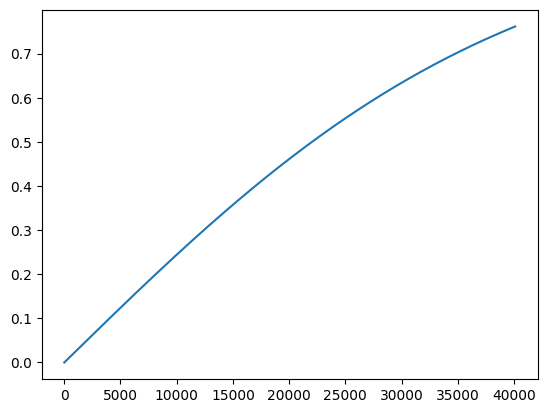

In [ ]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST as we assume this dataset is **unlabeled**.

In [ ]:
epochs = 70

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=0.01, momentum=0.9)

# mu0, alpha, beta = 0.01, 10, 0.75
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
# )
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  # grl_factor = 10
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    # grl_factor = 10
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = F.cross_entropy(cls_logits[:len(ys)], ys)

    bce = F.binary_cross_entropy_with_logits(
        domain_logits[:, 0],
        torch.cat((
            torch.ones(len(xs)),
            torch.zeros(len(xt))
        )).cuda()
    )
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 7)
  domain_loss = round(domain_loss / len(source_train_loader),7 )
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  # scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 1.1221905, domain loss: 0.1282447
GRL factor 0.011692311814172962
Epoch 1, class loss: 0.3712979, domain loss: 0.0461883
GRL factor 0.023381427149802958
Epoch 2, class loss: 0.2843826, domain loss: 0.0347245
GRL factor 0.035064153022842603
Epoch 3, class loss: 0.2376472, domain loss: 0.0187398
GRL factor 0.04673730343012039
Epoch 4, class loss: 0.206775, domain loss: 0.0179681
GRL factor 0.0583977028195235
Epoch 5, class loss: 0.1837825, domain loss: 0.0151722
GRL factor 0.0700421895359642
Epoch 6, class loss: 0.1638979, domain loss: 0.0145202
GRL factor 0.08166761923520971
Epoch 7, class loss: 0.1476785, domain loss: 0.0149112
GRL factor 0.09327086825777786
Epoch 8, class loss: 0.1289438, domain loss: 0.0130024
GRL factor 0.10484883695526359
Epoch 9, class loss: 0.1166403, domain loss: 0.0138234
GRL factor 0.11639845296164775
Epoch 10, class loss: 0.1009599, domain loss: 0.0139784
GRL factor 0.12791667440235055
Epoch 11, class loss: 0.0896593, domai

In [ ]:
class_acc,domain_acc,class_loss,domain_loss = eval_dann(dann, target_test_loader)
print(f"class acc: {class_acc}, domain acc: {domain_acc},class loss: {class_loss},domain loss: {domain_loss}")

class acc: 69.22, domain acc: 18.72,class loss: 4.29305,domain loss: 1.07619


## Target Only Training


In [ ]:
epochs = 70

naive_net_target = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net_target.parameters(), lr=0.01, momentum=0.9)

# mu0, alpha, beta = 0.01, 10, 0.75
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
# )

for epoch in range(epochs):
  train_loss = 0.

  for x, y in target_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net_target(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(target_train_loader), 5)}')
  # scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr' ]}")

test_acc, test_loss = eval_model(naive_net_target, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.34667
	Learning rate = 0.01
Epoch 1, train loss: 0.05263
	Learning rate = 0.01
Epoch 2, train loss: 0.03327
	Learning rate = 0.01
Epoch 3, train loss: 0.02553
	Learning rate = 0.01
Epoch 4, train loss: 0.02082
	Learning rate = 0.01
Epoch 5, train loss: 0.01755
	Learning rate = 0.01
Epoch 6, train loss: 0.01431
	Learning rate = 0.01
Epoch 7, train loss: 0.01166
	Learning rate = 0.01
Epoch 8, train loss: 0.00954
	Learning rate = 0.01
Epoch 9, train loss: 0.0088
	Learning rate = 0.01
Epoch 10, train loss: 0.00669
	Learning rate = 0.01
Epoch 11, train loss: 0.00637
	Learning rate = 0.01
Epoch 12, train loss: 0.00565
	Learning rate = 0.01
Epoch 13, train loss: 0.00479
	Learning rate = 0.01
Epoch 14, train loss: 0.00425
	Learning rate = 0.01
Epoch 15, train loss: 0.00341
	Learning rate = 0.01
Epoch 16, train loss: 0.00303
	Learning rate = 0.01
Epoch 17, train loss: 0.00227
	Learning rate = 0.01
Epoch 18, train loss: 0.00172
	Learning rate = 0.01
Epoch 19, train loss: 0

In [ ]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    # print(x.shape)
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

In [ ]:
from sklearn.manifold import TSNE

73257
Original embeddings of source / target (73257, 512) (60000, 512)
Samples embeddings (2000, 512) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

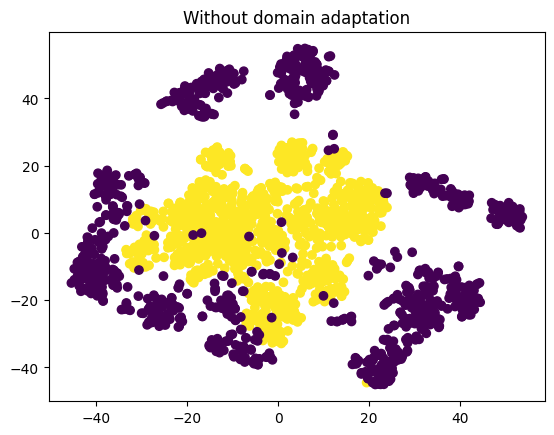

In [ ]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)
print(len(source_emb))

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb[:60000]))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (SVHN) dataset, while purple dots are the target dataset (MNIST). We can clearly see that they belong to different space if we use the naive model.

In [ ]:
source_emb_visual = extract_emb(naive_net, source_train_loader)
target_emb_visual= extract_emb(naive_net, target_train_loader)

In [ ]:
print(len(source_emb_visual[0]))

# plt.imshow(source_emb_visual[0].reshape(28,28), interpolation='nearest')

512


Yellow dots are the source (SVHN) dataset, while purple dots are the target dataset (MNIST). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (73257, 512) (60000, 512)
Samples embeddings (2000, 512) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

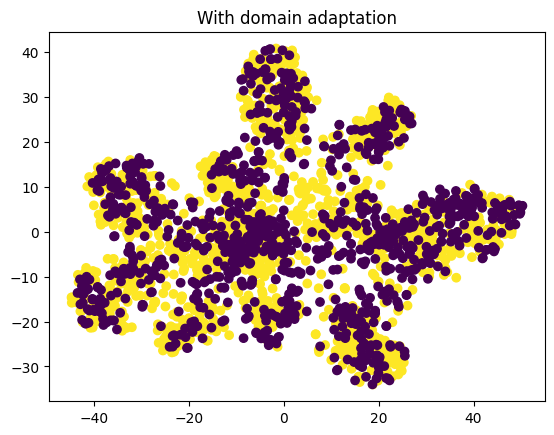

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb[:50000]))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

## Results 
**source only : 54**

**Proposed Approach:69.22**

**target only:99.13**

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling